# Install Requirements

In [3]:
%%writefile requirements.txt
langchain 
langchain-community 
chromadb 
langgraph
langchain-openai 
bitsandbytes
gradio

Overwriting requirements.txt


In [4]:
!pip install -qr requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 1.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 92.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.2/152.2 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 24.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.8/442.8 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Import Packages

In [5]:
import os
import chromadb
import requests
import json
import gradio as gr
import re
import numpy as np

from datasets import load_dataset
from chromadb.config import Settings
from huggingface_hub import hf_hub_download
from langchain_core.documents import Document
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, AutoModel, BitsAndBytesConfig

from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from typing import TypedDict, Annotated, Union
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END

2025-08-02 19:34:24.999279: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754163265.349687      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754163265.452371      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

# Read Data

In [6]:
import pandas as pd

df = pd.read_parquet("hf://datasets/openai/openai_humaneval/openai_humaneval/test-00000-of-00001.parquet")
df

,task_id,prompt,canonical_solution,test,entry_point
0,HumanEval/0,from typing import List\n\n\ndef has_close_ele...,"for idx, elem in enumerate(numbers):\n ...","\n\nMETADATA = {\n 'author': 'jt',\n 'da...",has_close_elements
1,HumanEval/1,from typing import List\n\n\ndef separate_pare...,result = []\n current_string = []\n ...,"\n\nMETADATA = {\n 'author': 'jt',\n 'da...",separate_paren_groups
2,HumanEval/2,\n\ndef truncate_number(number: float) -> floa...,return number % 1.0\n,"\n\nMETADATA = {\n 'author': 'jt',\n 'da...",truncate_number
3,HumanEval/3,from typing import List\n\n\ndef below_zero(op...,balance = 0\n\n for op in operations:\n...,"\n\nMETADATA = {\n 'author': 'jt',\n 'da...",below_zero
4,HumanEval/4,from typing import List\n\n\ndef mean_absolute...,mean = sum(numbers) / len(numbers)\n re...,"\n\nMETADATA = {\n 'author': 'jt',\n 'da...",mean_absolute_deviation
...,...,...,...,...,...
159,HumanEval/159,"\ndef eat(number, need, remaining):\n """"""\n...",if(need <= remaining):\n return [ n...,def check(candidate):\n\n # Check some simp...,eat
160,HumanEval/160,"\ndef do_algebra(operator, operand):\n """"""\...",expression = str(operand[0])\n for oprt...,def check(candidate):\n\n # Check some simp...,do_algebra
161,HumanEval/161,"\ndef solve(s):\n """"""You are given a string...",flg = 0\n idx = 0\n new_str = list(s...,def check(candidate):\n\n # Check some simp...,solve
162,HumanEval/162,"\ndef string_to_md5(text):\n """"""\n Given...",import hashlib\n return hashlib.md5(tex...,def check(candidate):\n\n # Check some simp...,string_to_md5


# Embedding Model

In [7]:
embedding_model = HuggingFaceEmbeddings(
    model_name="BAAI/bge-large-en-v1.5",
    model_kwargs={"device": "cuda"},  # Choose based on your setup
    encode_kwargs={"normalize_embeddings": True}  # Important for BGE
)

/tmp/ipykernel_36/468533690.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

# Chroma VectorDB

In [8]:
#HumanEval Dataset
documents1 = [Document(page_content=prom, metadata={"task_id": task_id}) 
             for prom, task_id in zip(df["prompt"], df['task_id'])]
vectorstore = Chroma.from_documents(documents=documents1, embedding=embedding_model)

#MBPP Dataset
dataset_mbpp = load_dataset("mbpp", split="test[:]")


documents2 = [Document(page_content=text, metadata={"task_id": task_id}) 
             for task_id, text in zip(dataset_mbpp["task_id"], dataset_mbpp["text"])]
vectorstore.add_documents(documents2)

README.md: 0.00B [00:00, ?B/s]

full/train-00000-of-00001.parquet:   0%|          | 0.00/87.2k [00:00<?, ?B/s]

full/test-00000-of-00001.parquet:   0%|          | 0.00/116k [00:00<?, ?B/s]

full/validation-00000-of-00001.parquet:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

full/prompt-00000-of-00001.parquet:   0%|          | 0.00/7.88k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/374 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/90 [00:00<?, ? examples/s]

Generating prompt split:   0%|          | 0/10 [00:00<?, ? examples/s]

['9b309e44-cb24-4e47-9560-19645c7431a3',
 '59345232-ece7-44cd-b548-b9f0f6c9dd6b',
 '1ac2db9e-8c38-46d1-b566-21860109eed6',
 'a0221068-e63d-448e-acfc-ab2d27aa41df',
 '1943365b-c6a4-4fa8-811e-9145bd753f99',
 '629812ff-f18f-4801-a398-a7260abec802',
 'fde66551-7294-466e-8859-03d0fe612aa8',
 '882fab48-a1ea-4c25-8e24-cebaaa7304e0',
 '8a8236cf-1def-4ab2-a9fc-cdede6fbae88',
 '45413964-d3d1-4b8c-a467-e17a3f39cbb9',
 'ef4dd165-fd9f-4caa-9537-6a739047a5fd',
 '602e67a2-0e7f-44a4-8c7e-60afff8f8170',
 '8ee5919c-eddd-4733-a5c1-0614aa0bb1e1',
 '08c0277b-8e72-423a-8f47-d38043cd1dc4',
 '6ff78f3d-ef6f-4e53-8ebb-b3ca1b5dd0b8',
 '4f721fc6-7e6f-46ef-93e4-4e260f73c37f',
 'eaef3ad2-0da8-4508-a51f-c6c396a01625',
 '0b3d32fe-962a-4863-9119-06d7086d12c3',
 '3dae8ddf-69da-4bbe-a47c-c8883de73fc8',
 '177e2453-fb0c-4350-8ea5-39814f2c6f71',
 'ef697523-940d-4cc1-bab7-b7691aec1704',
 'be72f2ff-3d7b-4e1c-bbe4-283faadfeb51',
 '799e7b77-09fe-4b25-a5ed-32f69c90b386',
 'd217e853-ae38-4197-9f9b-07f18f265f68',
 'c6b8695b-e69c-

# Retriever

In [9]:
retrieved_docs = vectorstore.similarity_search("reverse a string", k=1)

for doc in retrieved_docs:
    print("Prompt:", doc.page_content)
    print("Task ID:", doc.metadata["task_id"])
    print(type(doc.metadata["task_id"]))

Prompt: Write a function to reverse strings in a given list of string values.
Task ID: 456
<class 'int'>


# LLM Generative Model


In [10]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-Coder-7B-Instruct", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-Coder-7B-Instruct", trust_remote_code=True, quantization_config=BitsAndBytesConfig(load_in_4bit=True), device_map="auto")

generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.33G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Device set to use cuda:0


In [21]:
#function for generating code Using RAG
def generate_code(query, models=model, tokenizers= tokenizer):

    docs = vectorstore.similarity_search(query, k=1)
    context = [doc.page_content for doc in docs][0]
    task_id = [doc.metadata['task_id'] for doc in docs][0]
    
    
    if isinstance(task_id, int): 
        if context in dataset_mbpp['text']:
            idx = dataset_mbpp['text'].index(context)
            code = dataset_mbpp['code'][idx]
            test_case = dataset_mbpp['test_list'][idx][0]
            match = re.search(r'assert\s+(\w+)\s*\(', test_case)

            if match:
                function_name = match.group(1)
                print(function_name)
            
        else:
            code = None
            print("None Issue")
    elif isinstance(task_id, str):
        
        if context in df['prompt'].values:
            code = df[df['prompt'] == context]["canonical_solution"].values[0]
        else:
            code= None
            print("None Issue")
    else:
        code = None
    
    
    prompt = f"""You are a Python code generator. Follow these precise instructions:
    
    1. Use the following functions in sequence when generating code:
    {code}
    
    2. This is your function name:
    {function_name}
    3. Test output very well.
    
    4. Task:
    {query}
    
    Only use the information provided above to generate Python code. Do not include explanations or any output other than the code itself.
    
    Your response should start with the Python code directly and end before test cases."""


    messages = [
        {"role": "system", "content": "You are only a Python code generator"},
        {"role": "user", "content": prompt}
    ]

    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer([text], return_tensors="pt", max_length=500).to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=500, do_sample=False)
    response = tokenizer.decode(outputs[0][inputs.input_ids.shape[-1]:], skip_special_tokens=True)

    return response

In [12]:
#function for generating code Using RAG
def generate_code_without_RAG(query, models=model, tokenizers= tokenizer):
    docs = vectorstore.similarity_search(query, k=1)
    context = [doc.page_content for doc in docs][0]
    task_id = [doc.metadata['task_id'] for doc in docs][0]

    if isinstance(task_id, int): 
        if context in dataset_mbpp['text']:
            idx = dataset_mbpp['text'].index(context)
            test_case = dataset_mbpp['test_list'][idx][0]
            match = re.search(r'assert\s+(\w+)\s*\(', test_case)
    
            if match:
                function_name = match.group(1)
                print(function_name)
    
    prompt = f"""You are a Python code generator. Follow these precise instructions:
    
    1. This is your function name:
    {function_name}
    2. Test output very well
    
    3. Task:
    {query}
    
    Only use the information provided above to generate Python code. Do not include explanations or any output other than the code itself.
    
    Your response should start with the Python code directly."""


    messages = [
        {"role": "system", "content": "You are only a Python code generator"},
        {"role": "user", "content": prompt}
    ]

    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer([text], return_tensors="pt", max_length=500).to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=500, do_sample=False)
    response = tokenizer.decode(outputs[0][inputs.input_ids.shape[-1]:], skip_special_tokens=True)

    return response

In [13]:
#function for explain code
def explain_code(code, models=model, tokenizers= tokenizer):
    
    prompt = f"""You are a Python code Explainer.
    Explain the code only without anything else:
------------------
{code}
------------------

Answer:"""

    messages = [
        {"role": "system", "content": "You are a Python code Explainer."},
        {"role": "user", "content": prompt}
    ]

    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer([text], return_tensors="pt").to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=512, do_sample=False)
    response = tokenizer.decode(outputs[0][inputs.input_ids.shape[-1]:], skip_special_tokens=True)

    return response

# Evaluate LLM using Correcteness

In [14]:
# Remove opening ```python and closing ```
def clean_markdown_code_block(code_block: str) -> str:
    lines = code_block.strip().splitlines()

    # Remove ```python from the top if present
    if lines and lines[0].strip().startswith("```python"):
        lines = lines[1:]

    # Remove trailing ``` if present
    if lines and lines[-1].strip() == "```":
        lines = lines[:-1]

    # Join lines and cut off anything after triple single or double quotes
    cleaned_code = "\n".join(lines)
    for triple_quote in ('```'):
        if triple_quote in cleaned_code:
            cleaned_code = cleaned_code.split(triple_quote)[0]

    return cleaned_code.strip()


In [15]:
# add test cases to ensure perfect execution
def evaluate_code_correctness(generated_code, test_list):
    test_code = "\n".join(test_list)
    clean_code = clean_markdown_code_block(generated_code) + "\n" + test_code
    print(clean_code)
    try:
        exec(clean_code)
        print("Excuted")
        return 1  # Correct
    except Exception as e:
        print("ERORRRRRRR")
        
        return 0  # Incorrect

In [18]:
#Evaluate our LLM withou RAG
queries = dataset_mbpp['text'][0:10]
tests = dataset_mbpp['test_list'][0:10]
acc_without = 0
count_without = 0

for query, test in zip(queries, tests):
    code_generatded_cleaned = clean_markdown_code_block(generate_code_without_RAG(query))
    acc_without += evaluate_code_correctness(code_generatded_cleaned, test[:])
    count_without += 1
    print(f'Executed - {acc_without}')
    print(f'Step number = {count_without}')

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


remove_Occ


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


def remove_Occ(s, char):
    first_occurrence = s.find(char)
    if first_occurrence != -1:
        s = s[:first_occurrence] + s[first_occurrence+1:]
    last_occurrence = s.rfind(char)
    if last_occurrence != -1:
        s = s[:last_occurrence] + s[last_occurrence+1:]
    return s

# Test cases
print(remove_Occ("hello world", "o"))  # Expected: hell wrld
print(remove_Occ("banana", "a"))       # Expected: bnnan
print(remove_Occ("apple", "p"))        # Expected: ale
print(remove_Occ("testcase", "z"))     # Expected: testcase (no 'z' found)
print(remove_Occ("mississippi", "i"))  # Expected: mississipp
assert remove_Occ("hello","l") == "heo"
assert remove_Occ("abcda","a") == "bcd"
assert remove_Occ("PHP","P") == "H"
hell wrld
bnan
ale
testcase
mssissipp
Excuted
Executed - 1
Step number = 1
sort_matrix


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


def sort_matrix(matrix):
    return sorted(matrix, key=lambda row: sum(row))
assert sort_matrix([[1, 2, 3], [2, 4, 5], [1, 1, 1]])==[[1, 1, 1], [1, 2, 3], [2, 4, 5]]
assert sort_matrix([[1, 2, 3], [-2, 4, -5], [1, -1, 1]])==[[-2, 4, -5], [1, -1, 1], [1, 2, 3]]
assert sort_matrix([[5,8,9],[6,4,3],[2,1,4]])==[[2, 1, 4], [6, 4, 3], [5, 8, 9]]
Excuted
Executed - 2
Step number = 2
count_common


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


def count_common(dictionary):
    from collections import Counter
    word_counts = Counter(dictionary.values())
    return word_counts.most_common()
assert count_common(['red','green','black','pink','black','white','black','eyes','white','black','orange','pink','pink','red','red','white','orange','white',"black",'pink','green','green','pink','green','pink','white','orange',"orange",'red']) == [('pink', 6), ('black', 5), ('white', 5), ('red', 4)]
assert count_common(['one', 'two', 'three', 'four', 'five', 'one', 'two', 'one', 'three', 'one']) == [('one', 4), ('two', 2), ('three', 2), ('four', 1)]
assert count_common(['Facebook', 'Apple', 'Amazon', 'Netflix', 'Google', 'Apple', 'Netflix', 'Amazon']) == [('Apple', 2), ('Amazon', 2), ('Netflix', 2), ('Facebook', 1)]
ERORRRRRRR
Executed - 2
Step number = 3
find_Volume


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


def find_Volume(base, height, length):
    return (base * height * length) / 2

# Test cases
print(find_Volume(3, 4, 5))  # Expected output: 30.0
print(find_Volume(6, 8, 10)) # Expected output: 240.0
print(find_Volume(2, 2, 2))  # Expected output: 4.0
assert find_Volume(10,8,6) == 240
assert find_Volume(3,2,2) == 6
assert find_Volume(1,2,1) == 1
30.0
240.0
4.0
Excuted
Executed - 3
Step number = 4
split_lowerstring


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


import re

def split_lowerstring(s):
    return re.findall('[a-z][^a-z]*', s)

# Test cases
print(split_lowerstring('helloWorld'))  # ['hello', 'World']
print(split_lowerstring('splitCamelCaseHere'))  # ['split', 'Camel', 'Case', 'Here']
print(split_lowerstring('oneTwoThree'))  # ['one', 'Two', 'Three']
print(split_lowerstring('noSplitNeeded'))  # ['no', 'Split', 'Needed']
print(split_lowerstring('alreadyLowercase'))  # ['already', 'Lowercase']
assert split_lowerstring("AbCd")==['bC','d']
assert split_lowerstring("Python")==['y', 't', 'h', 'o', 'n']
assert split_lowerstring("Programming")==['r', 'o', 'g', 'r', 'a', 'm', 'm', 'i', 'n', 'g']
['h', 'e', 'l', 'l', 'oW', 'o', 'r', 'l', 'd']
['s', 'p', 'l', 'i', 'tC', 'a', 'm', 'e', 'lC', 'a', 's', 'eH', 'e', 'r', 'e']
['o', 'n', 'eT', 'w', 'oT', 'h', 'r', 'e', 'e']
['n', 'oS', 'p', 'l', 'i', 'tN', 'e', 'e', 'd', 'e', 'd']
['a', 'l', 'r', 'e', 'a', 'd', 'yL', 'o', 'w', 'e', 'r', 'c', 'a', 's', 'e']
Excuted
Executed - 4
Step number = 5
text_l

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


import re

def text_lowercase_underscore(text):
    pattern = r'^[a-z]+_[a-z]+$'
    return bool(re.match(pattern, text))

# Test cases
print(text_lowercase_underscore("hello_world"))  # True
print(text_lowercase_underscore("Hello_world"))  # False
print(text_lowercase_underscore("hello_World"))  # False
print(text_lowercase_underscore("hello_world_2"))  # False
print(text_lowercase_underscore("hello"))  # False
print(text_lowercase_underscore("world"))  # False
assert text_lowercase_underscore("aab_cbbbc")==('Found a match!')
assert text_lowercase_underscore("aab_Abbbc")==('Not matched!')
assert text_lowercase_underscore("Aaab_abbbc")==('Not matched!')
True
False
False
False
False
False
ERORRRRRRR
Executed - 4
Step number = 6
square_perimeter


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


def square_perimeter(side_length):
    return 4 * side_length

# Test cases
print(square_perimeter(5))  # Expected output: 20
print(square_perimeter(7))  # Expected output: 28
print(square_perimeter(1))  # Expected output: 4
assert square_perimeter(10)==40
assert square_perimeter(5)==20
assert square_perimeter(4)==16
20
28
4
Excuted
Executed - 5
Step number = 7
remove_dirty_chars


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


def remove_dirty_chars(str1, str2):
    return ''.join([char for char in str1 if char not in str2])

# Test cases
print(remove_dirty_chars("hello", "eo"))  # Expected: "hll"
print(remove_dirty_chars("abcdefg", "adfg"))  # Expected: "bc"
print(remove_dirty_chars("Python", "nohtyP"))  # Expected: ""
print(remove_dirty_chars("123456789", "2468"))  # Expected: "13579"
assert remove_dirty_chars("probasscurve", "pros") == 'bacuve'
assert remove_dirty_chars("digitalindia", "talent") == 'digiidi'
assert remove_dirty_chars("exoticmiles", "toxic") == 'emles' 
hll
bce

13579
Excuted
Executed - 6
Step number = 8
test_duplicate


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


def test_duplicate(arr):
    seen = set()
    for num in arr:
        if num in seen:
            return True
        seen.add(num)
    return False

# Test cases
print(test_duplicate([1, 2, 3, 4]))  # Output: False
print(test_duplicate([1, 2, 3, 3]))  # Output: True
print(test_duplicate([5, 5, 5, 5]))  # Output: True
print(test_duplicate([]))            # Output: False
print(test_duplicate([7]))           # Output: False
assert test_duplicate(([1,2,3,4,5]))==False
assert test_duplicate(([1,2,3,4, 4]))==True
assert test_duplicate([1,1,2,2,3,3,4,4,5])==True
False
True
True
False
False
Excuted
Executed - 7
Step number = 9
is_woodall
def is_woodall(n):
    if n <= 0:
        return False
    k = 0
    while (k * (k + 1) // 2) < n:
        k += 1
    return (k * (k + 1) // 2) == n

# Test cases
print(is_woodall(7))   # True, because 4*5/2 = 10 - 3 = 7
print(is_woodall(15))  # False, because no k satisfies k*(k+1)/2 = 15
print(is_woodall(1))   # True, because 0*(0+1)/2 = 1
print(is_woodall(

In [25]:
#Evaluate our LLM withou RAG
queries = dataset_mbpp['text'][0:10]
tests = dataset_mbpp['test_list'][0:10]
acc = 0
count = 0

for query, test in zip(queries, tests):
    code_generatded_cleaned = clean_markdown_code_block(generate_code(query))
    acc += evaluate_code_correctness(code_generatded_cleaned, test[:])
    count += 1
    print(f'Executed - {acc}')
    print(f'Step number = {count}')

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


remove_Occ


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


def remove_Occ(s, ch):
    for i in range(len(s)):
        if s[i] == ch:
            s = s[:i] + s[i+1:]
            break
    for i in range(len(s) - 1, -1, -1):
        if s[i] == ch:
            s = s[:i] + s[i+1:]
            break
    return s

# Test cases
print(remove_Occ("hello world", "l"))  # Expected: "heo word"
print(remove_Occ("banana", "a"))       # Expected: "bnnan"
print(remove_Occ("testcase", "t"))     # Expected: "estcas"
print(remove_Occ("single", "g"))       # Expected: "sinle"
print(remove_Occ("nochange", "z"))     # Expected: "nochange"
assert remove_Occ("hello","l") == "heo"
assert remove_Occ("abcda","a") == "bcd"
assert remove_Occ("PHP","P") == "H"
helo word
bnan
escase
sinle
nochange
Excuted
Executed - 1
Step number = 1
sort_matrix


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


def sort_matrix(M):
    result = sorted(M, key=sum)
    return result

# Test cases
matrix1 = [[3, 2, 1], [6, 5, 4], [9, 8, 7]]
sorted_matrix1 = sort_matrix(matrix1)
print(sorted_matrix1)  # Output: [[3, 2, 1], [6, 5, 4], [9, 8, 7]]

matrix2 = [[1, 1, 1], [2, 2, 2], [3, 3, 3]]
sorted_matrix2 = sort_matrix(matrix2)
print(sorted_matrix2)  # Output: [[1, 1, 1], [2, 2, 2], [3, 3, 3]]

matrix3 = [[-1, -2, -3], [-6, -5, -4], [-9, -8, -7]]
sorted_matrix3 = sort_matrix(matrix3)
print(sorted_matrix3)  # Output: [[-1, -2, -3], [-6, -5, -4], [-9, -8, -7]]
assert sort_matrix([[1, 2, 3], [2, 4, 5], [1, 1, 1]])==[[1, 1, 1], [1, 2, 3], [2, 4, 5]]
assert sort_matrix([[1, 2, 3], [-2, 4, -5], [1, -1, 1]])==[[-2, 4, -5], [1, -1, 1], [1, 2, 3]]
assert sort_matrix([[5,8,9],[6,4,3],[2,1,4]])==[[2, 1, 4], [6, 4, 3], [5, 8, 9]]
[[3, 2, 1], [6, 5, 4], [9, 8, 7]]
[[1, 1, 1], [2, 2, 2], [3, 3, 3]]
[[-9, -8, -7], [-6, -5, -4], [-1, -2, -3]]
Excuted
Executed - 2
Step number = 2
count_common


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


from collections import Counter

def count_common(words):
    word_counts = Counter(words)
    top_four = word_counts.most_common(4)
    return top_four
assert count_common(['red','green','black','pink','black','white','black','eyes','white','black','orange','pink','pink','red','red','white','orange','white',"black",'pink','green','green','pink','green','pink','white','orange',"orange",'red']) == [('pink', 6), ('black', 5), ('white', 5), ('red', 4)]
assert count_common(['one', 'two', 'three', 'four', 'five', 'one', 'two', 'one', 'three', 'one']) == [('one', 4), ('two', 2), ('three', 2), ('four', 1)]
assert count_common(['Facebook', 'Apple', 'Amazon', 'Netflix', 'Google', 'Apple', 'Netflix', 'Amazon']) == [('Apple', 2), ('Amazon', 2), ('Netflix', 2), ('Facebook', 1)]
ERORRRRRRR
Executed - 2
Step number = 3
find_Volume


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


def find_Volume(l, b, h):
    return (l * b * h) / 2

# Test cases
print(find_Volume(3, 4, 5))  # Expected output: 30.0
print(find_Volume(6, 8, 10)) # Expected output: 240.0
print(find_Volume(2, 2, 2))  # Expected output: 4.0
assert find_Volume(10,8,6) == 240
assert find_Volume(3,2,2) == 6
assert find_Volume(1,2,1) == 1
30.0
240.0
4.0
Excuted
Executed - 3
Step number = 4
split_lowerstring


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


import re

def split_lowerstring(text):
    return re.findall('[a-z][^a-z]*', text)
assert split_lowerstring("AbCd")==['bC','d']
assert split_lowerstring("Python")==['y', 't', 'h', 'o', 'n']
assert split_lowerstring("Programming")==['r', 'o', 'g', 'r', 'a', 'm', 'm', 'i', 'n', 'g']
Excuted
Executed - 4
Step number = 5
text_lowercase_underscore


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


import re

def text_lowercase_underscore(text):
    patterns = '^[a-z]+_[a-z]+$'
    if re.search(patterns, text):
        return 'Found a match!'
    else:
        return 'Not matched!'
assert text_lowercase_underscore("aab_cbbbc")==('Found a match!')
assert text_lowercase_underscore("aab_Abbbc")==('Not matched!')
assert text_lowercase_underscore("Aaab_abbbc")==('Not matched!')
Excuted
Executed - 5
Step number = 6
square_perimeter


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


def square_perimeter(a):
    perimeter = 4 * a
    return perimeter
assert square_perimeter(10)==40
assert square_perimeter(5)==20
assert square_perimeter(4)==16
Excuted
Executed - 6
Step number = 7
remove_dirty_chars


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


NO_OF_CHARS = 256

def str_to_list(string):
    temp = []
    for x in string:
        temp.append(x)
    return temp

def lst_to_string(List):
    return ''.join(List)

def get_char_count_array(string):
    count = [0] * NO_OF_CHARS
    for i in string:
        count[ord(i)] += 1
    return count

def remove_dirty_chars(string, second_string):
    count = get_char_count_array(second_string)
    ip_ind = 0
    res_ind = 0
    temp = ''
    str_list = str_to_list(string)
    while ip_ind != len(str_list):
        temp = str_list[ip_ind]
        if count[ord(temp)] == 0:
            str_list[res_ind] = str_list[ip_ind]
            res_ind += 1
        ip_ind += 1
    return lst_to_string(str_list[0:res_ind])
assert remove_dirty_chars("probasscurve", "pros") == 'bacuve'
assert remove_dirty_chars("digitalindia", "talent") == 'digiidi'
assert remove_dirty_chars("exoticmiles", "toxic") == 'emles' 
Excuted
Executed - 7
Step number = 8
test_duplicate


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


def test_duplicate(arraynums):
    nums_set = set(arraynums)
    return len(arraynums) != len(nums_set)

# Test cases
print(test_duplicate([1, 2, 3, 4]))  # Output: False (no duplicates)
print(test_duplicate([1, 2, 3, 3]))  # Output: True (contains duplicates)
print(test_duplicate([5, 5, 5, 5]))  # Output: True (contains duplicates)
print(test_duplicate([]))            # Output: False (empty list)
print(test_duplicate([7]))           # Output: False (single element)
assert test_duplicate(([1,2,3,4,5]))==False
assert test_duplicate(([1,2,3,4, 4]))==True
assert test_duplicate([1,1,2,2,3,3,4,4,5])==True
False
True
True
False
False
Excuted
Executed - 8
Step number = 9
is_woodall
def is_woodall(x):
    if (x % 2 == 0): 
        return False
    if (x == 1): 
        return True
    x = x + 1 
    p = 0
    while (x % 2 == 0): 
        x = x / 2
        p = p + 1
        if (p == x): 
            return True
    return False

# Test cases
print(is_woodall(1))  # True
print(is_woodall(3))  # 

In [26]:
print(f'Correctness of our LLM (without RAG) = {(acc_without / 10) * 100 }%')
print(f'Correctness of our LLM (wit RAG) = {(acc / 10) * 100 }%')


Correctness of our LLM (without RAG) = 70.0%
Correctness of our LLM (wit RAG) = 90.0%


# LangGraph

In [27]:
class AgentState(TypedDict):
    messages: list[Union[HumanMessage, AIMessage]]
    
    will_gen: int
    will_exp: int
    
    query: Annotated[list[HumanMessage], add_messages]
    code: Annotated[list[HumanMessage], add_messages]

    gen: Annotated[list[AIMessage], add_messages]
    exp: Annotated[list[AIMessage], add_messages]

In [28]:
#Using a LLM model, we decide if the input is generation or explaination task 
def inputs(state: AgentState) -> AgentState:
    last_msg = state["messages"][-1].content

    # Define chat-style messages
    messages = [
        {"role": "system", "content": (
            "You are a smart classifier that decides if the user's intent is to generate code or explain code. "
            "Respond ONLY with a JSON object in this format:\n"
            '{ "task": "generate" or "explain", "user_input": "<copy of user message>" }'
        )},
        {"role": "user", "content": last_msg}
    ]

    # Call model
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer([text], return_tensors="pt").to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=512, do_sample=False)
    response = tokenizer.decode(outputs[0][inputs.input_ids.shape[-1]:], skip_special_tokens=True)

    # Extract JSON
    try:
        json_start = response.find("{")
        json_str = response[json_start:]
        task_info = json.loads(json_str)
    except Exception as e:
        raise ValueError(f"Failed to parse JSON from model: {raw_output}") from e

    task = task_info["task"]
    user_input = task_info["user_input"]

    if task == "generate":
        state["will_gen"] = 1
        state["will_exp"] = 0
        state["query"] = [HumanMessage(content=user_input)]
    else:
        state["will_gen"] = 0
        state["will_exp"] = 1
        state["code"] = [HumanMessage(content=user_input)]

    return state


In [29]:
def generate(state:AgentState) -> AgentState:
    """This function generate code using query"""
    state['gen'] = [AIMessage(content=generate_code(state["query"][-1].content))]
    state['messages'].append(AIMessage(content=generate_code(state["query"][-1].content)))
    return state

In [30]:
def explain(state:AgentState) -> AgentState:
    '''This function explain the code'''
    state['exp'] = [AIMessage(content=explain_code(state["code"][-1].content))]
    return state

In [31]:
def decide_next_node(state:AgentState) -> AgentState:
    '''This function decide to generate or explain the input'''
    if state["will_gen"] == 1:
        return "Generating"
    else:
        return "Explaining"

In [32]:
graph = StateGraph(AgentState)

graph.add_node("Input", inputs)
graph.add_node("generate_code", generate)
graph.add_node("explain_code", explain)
graph.add_node("router1", lambda state: state)


graph.add_edge(START, "Input") 
graph.add_edge("Input", "router1") 

graph.add_conditional_edges(
    "router1",
    decide_next_node,
    {
        "Generating": "generate_code",
        "Explaining": "explain_code"
    }
    
)

graph.add_edge("generate_code", END)
graph.add_edge("explain_code", END)

app = graph.compile()

# Schema

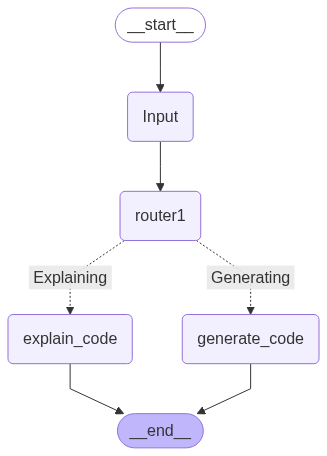

In [33]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

# Gradio Deployment

In [35]:
dataset_mbpp['text'][10:20]

['Write a function to find m number of multiples of n.',
 'Write a function to find the first duplicate element in a given array of integers.',
 'Write a python function to find the maximum sum of elements of list in a list of lists.',
 'Write a function to convert the given binary number to its decimal equivalent.',
 'Write a python function to find the product of non-repeated elements in a given array.',
 'Write a function to check if the given tuple list has all k elements.',
 'Write a python function to remove all digits from a list of strings.',
 'Write a python function to find binomial co-efficient.',
 'Write a python function to find the element occurring odd number of times.',
 'Write a python function to count all the substrings starting and ending with same characters.']

In [36]:
chat_history = []
explain_generated = False
def chat_with_bot(user_input, history):
    global chat_history, explain_generated 

    if explain_generated == True:
        if user_input.lower() == 'yes':
            result = app.invoke({"messages" : chat_history, "will_exp": 1})
            explain_generated = False
            return result['exp'][-1].content
        else:
            explain_generated = False
            return 'Tell me what you need'
            


    chat_history.append(HumanMessage(content=user_input))
    result = app.invoke({"messages" : chat_history})
    chat_history = result['messages']

    if result['will_gen'] == 1:
        explain_generated = True
        return result['gen'][-1].content + "\n\n" + "Do you want from me to explain the code?"
        
    elif result['will_exp'] == 1:
        explain_generated = False
        return result['exp'][-1].content


gr.ChatInterface(
    fn=chat_with_bot,
    title="Code Helper Bot",
    description="Ask me to write or explain code. I can also explain generated code if you want!",
    theme="soft"
).launch()

/usr/local/lib/python3.11/dist-packages/gradio/chat_interface.py:339: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  self.chatbot = Chatbot(


* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://1b59a1da52b86ade4a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


get_Odd_Occurrence


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


get_Odd_Occurrence


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
